# Import stuff

In [70]:
# imports
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.gesturestream as grstream
from gesturerec.data import SensorData
from gesturerec.data import GestureSet
from gesturerec.experiments import Experiments
from gesturerec.experiments import ClassificationResults
from gesturerec.experiments import TrialClassificationResult
import fastdtw
from dtaidistance import dtw
from cdtw import pydtw

# Load the data

In [71]:
# Load the data
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

print("The selected gesture set:", selected_gesture_set)

Found the following gesture log sub-directories
['AGestures', 'AlexandraGestures', 'AlexisGestures', 'AnjaliGestures', 'BrettGestures', 'BryanGestures', 'ClayGestures', 'DustinGestures', 'EmmaGestures', 'JaeHGestures', 'JasonGestures', 'JonGestures', 'JuliaBGestures', 'JustinGestures', 'MattCGestures', 'MattGestures', 'MikaelGestures', 'NanGestures', 'NeilGestures', 'NickGestures', 'NooseGestures', 'Paf2Gestures', 'SamuelRGestures', 'ShaunGestures', 'StacyGestures', 'ThweidGestures', 'WolfGestures']
Creating a GestureSet object for path './GestureLogs\AGestures'
Found 55 csv files in ./GestureLogs\AGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 tri

AttributeError: 'NoneType' object has no attribute 'gesture_name'

# Preprocess the data

In [79]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    '''
     mag_detrended = sp.signal.detrend(s) 
    low_pass_cutoff_freq = 5
    sampling_rate = 90
    filter_order = 3
    nyquist_freq = 0.5 * sampling_rate
    sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
    mag_butter_filter = signal.sosfilt(sos, mag_detrended)
    '''
    detrended = sp.signal.detrend(s) 
    low_pass_cutoff_freq = 3
    sampling_rate = 90
    filter_order = 3
    nyquist_freq = 0.5 * sampling_rate
    sos = signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
    butter_filtered_data = signal.sosfilt(sos, detrended)
    avg = np.average(butter_filtered_data)
    demeaned_data = butter_filtered_data - avg
    processed_signal = demeaned_data
    
    #mean_filter_window_size = 5
    #processed_signal = np.convolve(s, np.ones((mean_filter_window_size,))/mean_filter_window_size, mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)
    print(f"Processed {str(gesture_set)}")
print("Pre-processed all data")

Processed './GestureLogs\AGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\AlexandraGestures' : 11 gestures and 56 total trials
Processed './GestureLogs\AlexisGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\AnjaliGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\BrettGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\BryanGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\ClayGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\DustinGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\EmmaGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\JaeHGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\JasonGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\JonGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\JuliaBGestures' : 11 gestures and 55 total trials
Processed './GestureLogs\JustinGestures

## K-Fold Cross Validation Methods

In [80]:
# The k-fold cross validation methods

# TODO: write your own kfolds method here
def generate_kfolds(num_folds, gesture_set, seed=None):
    '''
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments)
    
    num_folds : the number of folds
    gesture_set : the gesture set for splitting into k-folds
    seed : an integer seed value (pass in the same seed value to get the same split across multiple executions)
    '''
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        if num_folds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(num_folds, gesture_name, len(trials)))
            
    # TODO
    list_folds = []
    random.seed(seed)
    gestures = {}
    for gesture in gesture_set.get_gesture_names_sorted():
        gesture = str(gesture)
        trials = list(gesture_set.get_trials_for_gesture(gesture))
        random.shuffle(trials)
        gestures[gesture] = trials        
    for i in range(num_folds):
        fold = {}
        for gesture in gesture_set.get_gesture_names_sorted():
            # TODO 
            trial = gestures[str(gesture)].pop()
            fold[str(gesture)] = trial
        list_folds.append(fold)
    check_folds(list_folds) # for debugging. You can comment this out
    return list_folds # each index of the list represents a fold, which contains a map of gesture names to trials

from sklearn.model_selection import StratifiedKFold
def generate_kfolds_scikit(num_folds, gesture_set, seed=None):
    trials = []
    trial_nums = []
    gesture_names = []
    for gesture_name, gesture_trials in gesture_set.map_gestures_to_trials.items():
        for trial in gesture_trials:
            trials.append(trial)
            trial_nums.append(trial.trial_num)
            gesture_names.append(gesture_name)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    # Iterate through the splits and setup our data structure
    fold_cnt = 0
    list_folds = list()
    for train_idx, test_idx in skf.split(trials, gesture_names):
        cur_fold_map_gesture_to_trial = dict()
        for i in test_idx:
            cur_fold_map_gesture_to_trial[gesture_names[i]] = trials[i]
        list_folds.append(cur_fold_map_gesture_to_trial)    
        fold_cnt += 1
    return list_folds

def print_folds(list_folds):
    '''
    Prints out the folds (useful for debugging)
    '''
    # print out folds (for debugging)
    fold_index = 0
    if fold_index == 0:
        for fold in list_folds:
            print("Fold: ", fold_index)
            for gesture_name, trial in fold.items():
                print("\t{} Trial: {}".format(gesture_name, trial.trial_num))
            fold_index = fold_index + 1
            
def check_folds(folds):
    '''
    Checks to see that the folds are appropriately setup (useful for debugging)
    Throw an exception if there appears to be a problem
    '''
    for test_fold_idx in range(0, len(folds)):
        # check to make sure test data is not in training data
        for test_gesture, test_trial in folds[test_fold_idx].items():
            # search for this test_gesture and trial_num in all other folds
            # it shouldn't be there!
            for train_fold_idx in range(0, len(folds)):
                if test_fold_idx != train_fold_idx:
                    for train_gesture, train_trial in folds[train_fold_idx].items():
                        if test_gesture == train_gesture and test_trial.trial_num == train_trial.trial_num:
                            raise Exception("Uh oh, gesture '{}' trial '{}' was found in both test fold '{}' and\
                                             training fold '{}.' Training folds should not include test data".format(
                                            test_gesture, test_trial.trial_num, test_fold_idx, train_fold_idx))



## The matching algorithms

We have a top-level function called `run_match_algorithm`, which takes in a list of folds (setup for k-fold cross validation) and a "pointer" to a `find_closest_match_alg` algorithm, which may take one or more arguments (from `**kwargs`)

In [81]:
from scipy.spatial import distance
import time

def run_matching_algorithm(list_folds, find_closest_match_alg, **kwargs):
    '''
    Our primary matching algorithm function that takes in a fold, a matching algorithm, and optional 
    arguments (**kwargs) for that matching alg. Returns a ClassificationResults object
    
    list_folds : the folds generated by generate_kfolds
    find_closest_match_alg : "pointer" to the closest match function you want to test
    kwargs : optional arguments to pass to find_closest_match_alg
    '''
    
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
    
    fold_index = 0
    map_gesture_name_to_list_results = dict()
    for fold in list_folds:
        if verbose:
            print("\n**FOLD: {}**".format(fold_index))
            
        correctness_cnt_for_fold = 0
        elapsed_time_for_fold = 0
        for test_gesture_name, test_trial in fold.items():
            template_folds = list_folds[0:fold_index] + list_folds[fold_index + 1:len(list_folds)]
            template_trials = list()
            for fold in template_folds:
                for template_gesture_name, template_trial in fold.items():
                    template_trials.append(template_trial)
            
            start_time = time.time()
            trial_classification_result = find_closest_match_alg(test_trial, template_trials, **kwargs)
            elapsed_time_in_secs = time.time() - start_time
            trial_classification_result.fold_idx = fold_index
            trial_classification_result.elapsed_time = elapsed_time_in_secs
            elapsed_time_for_fold += elapsed_time_in_secs
            
            if trial_classification_result.is_correct:
                correctness_cnt_for_fold += 1
            
            if verbose:
                print(trial_classification_result)
            
            # track overall results across comparisons
            if test_gesture_name not in map_gesture_name_to_list_results:
                map_gesture_name_to_list_results[test_gesture_name] = list()
            map_gesture_name_to_list_results[test_gesture_name].append(trial_classification_result)
            
        # print out overall fold accuracy
        fold_accuracy = (correctness_cnt_for_fold / len(fold)) * 100;
        if verbose:
            print("COMPLETED FOLD: {} IN {:0.3f} SECS WITH ACCURACY {}/{} ({:0.1f}%)".
                  format(fold_index, elapsed_time_for_fold, correctness_cnt_for_fold, len(fold), fold_accuracy))

        fold_index = fold_index + 1
    
    classification_result = ClassificationResults(find_closest_match_alg.__name__, 
                                                  map_gesture_name_to_list_results, **kwargs)
    return classification_result
            

## The matching algorithms

In [99]:
def find_closest_match_euclid_signal(test_trial, template_trials, **kwargs):
    if 'signal_var_name' not in kwargs:
        signal_var_name = "mag_p"
    else:
        signal_var_name = kwargs['signal_var_name']
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        euclid_distance = distance.euclidean(test_trial_signal, template_trial_signal)

        n_best_list_tuple.append((template_trial, euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result

# For example, how about writing a DTW-based algorithm here. 
def find_closest_match_dtw(test_trial, template_trials, signal_var_name="mag_p", **kwargs):
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        test_array = np.array(test_trial_signal,dtype=np.double)
        template_array = np.array(template_trial_signal,dtype=np.double)
        distance = pydtw.dtw(test_array, template_array, pydtw.Settings(compute_path=False, norm=True, dist="euclid")).get_dist()
        n_best_list_tuple.append((template_trial, distance))
    return TrialClassificationResult(test_trial, n_best_list_tuple) 

def find_closest_match_dtw_x(test_trial, template_trials, **kwargs):
    return find_closest_match_dtw(test_trial, template_trials, "x_p")
def find_closest_match_dtw_y(test_trial, template_trials, **kwargs):
    return find_closest_match_dtw(test_trial, template_trials, "y_p")
def find_closest_match_dtw_z(test_trial, template_trials, **kwargs):
    return find_closest_match_dtw(test_trial, template_trials, "z_p")

def get_normalized_fft(data):
    try:
        sampling_rate = 100
        num_samples = 100 # we want 50 bins?
        
        test_fft = np.abs(np.fft.fft(data - np.mean(data)))
        test_freqs = np.fft.fftfreq(len(data))
        test_freqs = test_freqs * sampling_rate # convert normalized freq bins to our freq bins

        test_freqs = test_freqs[range(num_samples//2)] # one side freq range, integer division
        abs_fft = np.abs(test_fft)[range(num_samples//2)] # one side freq range, integer division
        abs_fft_normalized = abs_fft / num_samples # normalize to values 0 - 1
        # print(f"{len(abs_fft_normalized)} bins")
        return abs_fft_normalized
    except IndexError:
        print("We don't know what to do here!")
        return None # we're just going to say 100 on this one?

def find_closest_match_fft(test_trial, template_trials, signal_var_name="mag_p", **kwargs):
    # Remember, your 'scoring' function is whatever *you* want--it could combine distance calculations across
    # x, y, z, and mag--or just one of those signals. And it can use whatever similarity measure you decide upon!
    # What about finding the best alignment between signals before computing a similarity measure?
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        test_trial_signal = getattr(test_trial.accel, signal_var_name)
        template_trial_signal = getattr(template_trial.accel, signal_var_name)
        # TODO: implement this
        test_trial_fft = get_normalized_fft(test_trial_signal)
        template_trial_fft = get_normalized_fft(template_trial_signal)
        if test_trial_fft is None or template_trial_fft is None:
            continue
        euclid_distance = distance.euclidean(test_trial_fft, template_trial_fft)
        
        
        n_best_list_tuple.append((template_trial, euclid_distance))
    if len(n_best_list_tuple) == 0:
        return None
    return TrialClassificationResult(test_trial, n_best_list_tuple) 

def find_closest_match_fft_x(test_trial, template_trials, **kwargs):
    return find_closest_match_fft(test_trial, template_trials, "x_p")
def find_closest_match_fft_y(test_trial, template_trials, **kwargs):
    return find_closest_match_fft(test_trial, template_trials, "y_p")
def find_closest_match_fft_z(test_trial, template_trials, **kwargs):
    return find_closest_match_fft(test_trial, template_trials, "z_p")


def plot_stacked_bar_graph_consensus(trial, guess_history):
    gesture_names = []
    scores = []
    for guess in guess_history:
        guess_scores = []
        for gesture_name in guess:
            if gesture_name not in gesture_names:
                gesture_names.append(gesture_name)
        for gesture_name in gesture_names:
            guess_scores.append(guess[gesture_name])
        scores.append(guess_scores)
    # create plot
    fig, ax = plt.subplots(figsize=(20, 5))
    bar_width = 0.35
    opacity = 0.8
    labels = gesture_names
    bottoms = np.zeros(len(labels))
    for index, score in enumerate(scores):
        label = f'Algo#{index}'
        ax.bar(labels, score, bar_width, label=label,bottom=bottoms)
        bottoms += score
        print(f"{label} {score}")
    
    ax.set_ylabel('Consesus Score')
    ax.set_title('Consesus Scores for ' + str(trial))
    # plt.xticks(index - bar_width, gesture_names, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

def find_match_bring_in_the_expert(test_trial, template_trials, **kwargs):
    algos = [find_closest_match_euclid_signal, find_closest_match_fft, find_closest_match_fft_x, find_closest_match_fft_y, find_closest_match_fft_z, find_closest_match_dtw, find_closest_match_dtw_x, find_closest_match_dtw_y, find_closest_match_dtw_z]
    # run the algo and run the next if we're not sure
    
    committee = kwargs["committee"] if 'committee' in kwargs else False
    verbose = kwargs["verbose"] if 'verbose' in kwargs else False
    if verbose:
        print(f"\n{test_trial.gesture_name}{committee}")
    sdfms = []
    guesses = {}
    trials = {}
    algos_run = 0
    guess_history = []
    for algo in algos:
        results = algo(test_trial, template_trials, **kwargs)
        if results is None:
            continue
        top_score = results.score
        _, scores = zip(*results.n_best_list_sorted)
        avg = np.average(scores)
        sd = np.std(scores)
        sdfm = (avg - top_score) /sd
        sdfms.append(f"{results.closest_trial.gesture_name}:{sdfm}")
        index = 1
        trials_looked_at = set()
        guess_history_item = {}
        for trial, score in results.n_best_list_sorted:
            trial_name = trial.gesture_name
            if trial_name not in trials:
                trials[trial_name] = trial
            if trial_name in trials_looked_at:
                continue
            if trial_name not in guesses:
                guesses[trial_name] = 0
            guesses[trial_name] += index
            guess_history_item[trial_name] = index
            
            trials_looked_at.add(trial_name)
            if index == 0:
                index += 1
            if index < (algos_run + 3):
                index += 1

        if not results.is_correct and verbose:
            print(f"Incorrect: SDFM:{sdfm} AVG: {avg} SC:{top_score} guess:{results.closest_trial.gesture_name} correct:{results.test_trial.get_ground_truth_gesture_name()} correct_index:{results.get_correct_match_index_nbestlist()}")
        guess_history.append(guess_history_item)
        # check how confident we are - must be 2 sd from mean and less than half of average
        if sdfm > 1.85 and algos_run > 0:
            break
        algos_run += 1
    if verbose:
        print(f"Trying to determine {test_trial} = {sdfms}")
        print(guesses)
    n_best_list_tuple = list()
    for item in guesses:
        trial = trials[item]
        n_best_list_tuple.append((trial, guesses[item]))
    committee_results = TrialClassificationResult(test_trial, n_best_list_tuple)
    if committee:
        if not committee_results.is_correct and verbose:
            plot_stacked_bar_graph_consensus(trial, guess_history)
        return committee_results
    return results

## Running Experiments

1
2
3
4

**FOLD: 0**

At RestTrue
Trying to determine 'At Rest' : Trial 4 from At Rest_1589326287694_678.csv = ['At Rest:1.9393403031856171', 'At Rest:1.7311645134000933']
{'At Rest': 2, "Midair 'S'": 4, 'Backhand Tennis': 6, 'Shake': 7, "Midair Counter-clockwise 'O'": 7, "Midair Clockwise 'O'": 7, "Midair Zorro 'Z'": 7, 'Forehand Tennis': 7, 'Underhand Bowling': 7, 'Baseball Throw': 7, 'Custom': 7}
Correct : Best match for 'At Rest' Trial 4 is 'At Rest' Trial 2 w/score: 2.0 (0.012s)

Backhand TennisTrue
Incorrect: SDFM:1.091771007387598 AVG: 5731.2121678353715 SC:1660.9343683265224 guess:Midair Clockwise 'O' correct:Backhand Tennis correct_index:2
Trying to determine 'Backhand Tennis' : Trial 4 from Backhand Tennis_1589325992236_212.csv = ['Backhand Tennis:1.719380624407686', 'Backhand Tennis:1.2627765737068102', 'Backhand Tennis:1.6214316083179923', "Midair Clockwise 'O':1.091771007387598", 'Backhand Tennis:0.9496708250235988', 'Backhand Tennis:1.798952371558742']
{'Backhand Tennis':

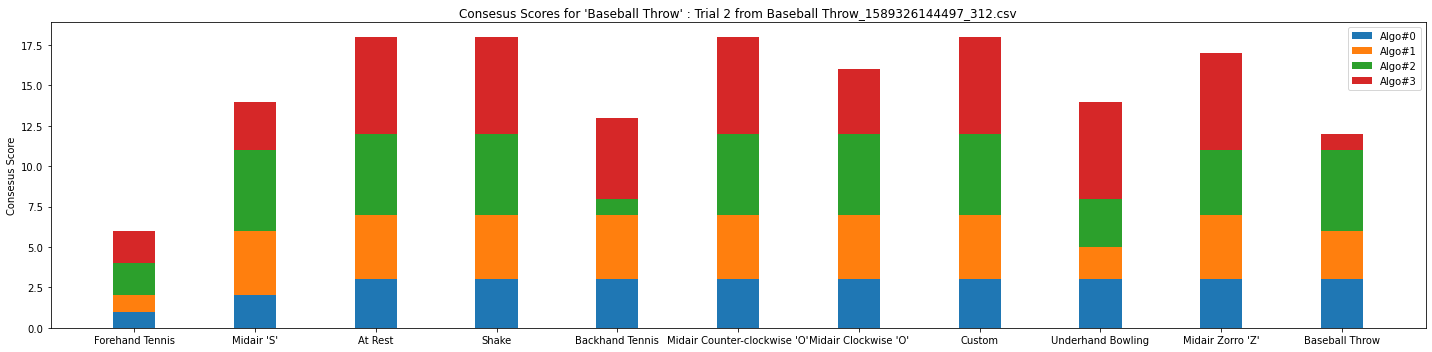

Incorrect : Best match for 'Baseball Throw' Trial 0 is 'Forehand Tennis' Trial 0 w/score: 6.0 (0.446s)

CustomTrue
Incorrect: SDFM:nan AVG: nan SC:nan guess:At Rest correct:Custom correct_index:1
Incorrect: SDFM:1.9738540788660603 AVG: 18273.932887830237 SC:15862.355283418528 guess:Forehand Tennis correct:Custom correct_index:5
Trying to determine 'Custom' : Trial 3 from Custom_1589326511003_358.csv = ['At Rest:nan', 'Forehand Tennis:1.9738540788660603']
{'At Rest': 5, 'Custom': 6, "Midair 'S'": 6, 'Backhand Tennis': 7, "Midair Counter-clockwise 'O'": 7, "Midair Clockwise 'O'": 7, 'Shake': 5, "Midair Zorro 'Z'": 7, 'Underhand Bowling': 7, 'Baseball Throw': 7, 'Forehand Tennis': 4}
Algo#0 [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Algo#1 [4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 1]


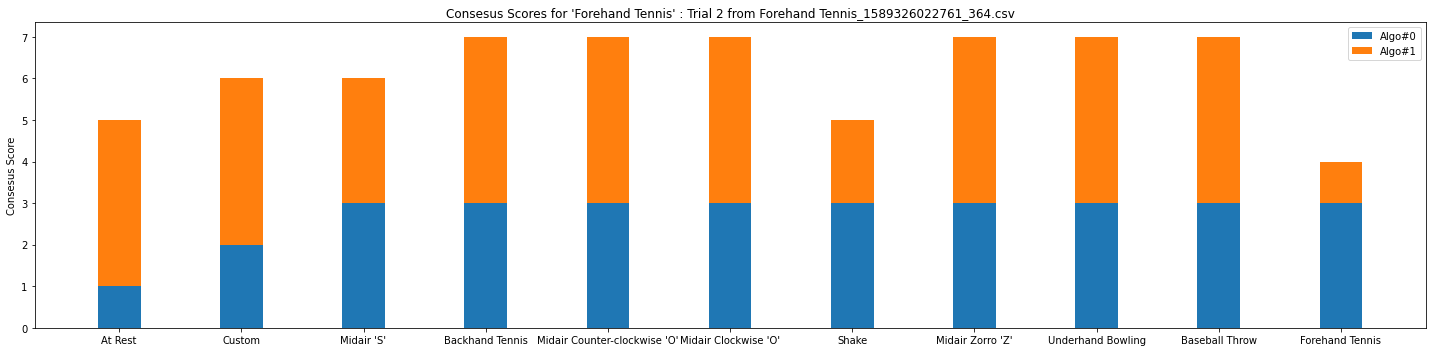

Incorrect : Best match for 'Custom' Trial 3 is 'Forehand Tennis' Trial 2 w/score: 4.0 (0.339s)

Forehand TennisTrue
Incorrect: SDFM:nan AVG: nan SC:nan guess:At Rest correct:Forehand Tennis correct_index:5
Incorrect: SDFM:1.2551152328391197 AVG: 7225.3466920621395 SC:1575.154478129225 guess:Backhand Tennis correct:Forehand Tennis correct_index:21
Incorrect: SDFM:1.6332092883549063 AVG: 6734.8758901940155 SC:1973.217875113718 guess:Midair Counter-clockwise 'O' correct:Forehand Tennis correct_index:13
Incorrect: SDFM:0.9274737441852459 AVG: 7124.049277347457 SC:743.543776611626 guess:Backhand Tennis correct:Forehand Tennis correct_index:1
Incorrect: SDFM:1.5079287173212135 AVG: 102.14332026945449 SC:41.58543733151075 guess:Backhand Tennis correct:Forehand Tennis correct_index:2
Incorrect: SDFM:2.218460020037087 AVG: 88.95581250027975 SC:23.026779958442575 guess:Backhand Tennis correct:Forehand Tennis correct_index:5
Trying to determine 'Forehand Tennis' : Trial 4 from Forehand Tennis_158

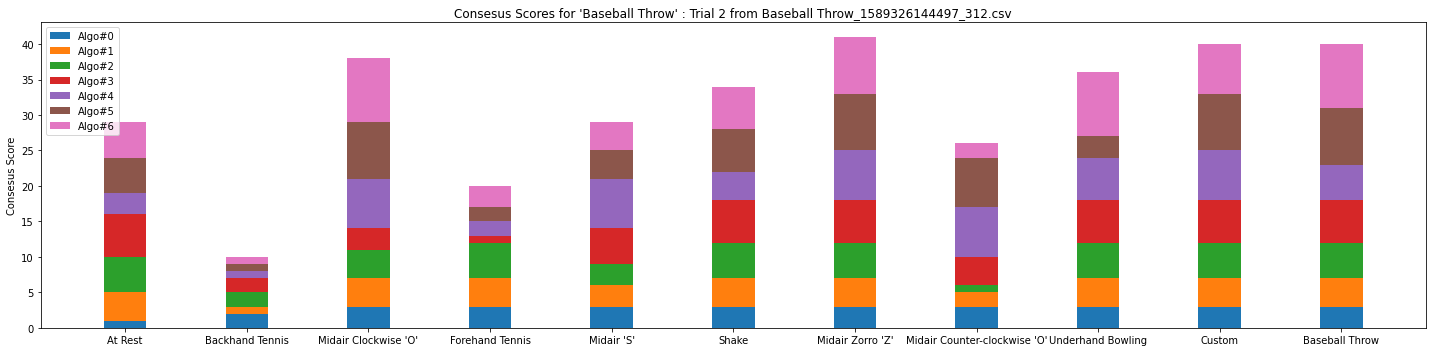

Incorrect : Best match for 'Forehand Tennis' Trial 4 is 'Backhand Tennis' Trial 1 w/score: 10.0 (0.804s)

Midair 'S'True
Incorrect: SDFM:nan AVG: nan SC:nan guess:At Rest correct:Midair 'S' correct_index:1
Incorrect: SDFM:1.660704443314862 AVG: 6809.9033336934945 SC:2436.398807294334 guess:Midair Clockwise 'O' correct:Midair 'S' correct_index:1
Trying to determine 'Midair 'S'' : Trial 3 from Midair _S__1589326397242_218.csv = ['At Rest:nan', "Midair 'S':1.2472549758901132", "Midair 'S':1.1782683695865876", "Midair Clockwise 'O':1.660704443314862", "Midair 'S':0.8760023867955883", "Midair 'S':1.5448418597881306", "Midair 'S':1.3128890258913024", "Midair 'S':1.4729269454099478", "Midair 'S':1.1364783476271545"]
{'At Rest': 39, "Midair 'S'": 11, "Midair Counter-clockwise 'O'": 37, "Midair Clockwise 'O'": 24, 'Shake': 46, 'Backhand Tennis': 46, 'Underhand Bowling': 57, 'Forehand Tennis': 49, "Midair Zorro 'Z'": 57, 'Baseball Throw': 56, 'Custom': 52}
Correct : Best match for 'Midair 'S'' T

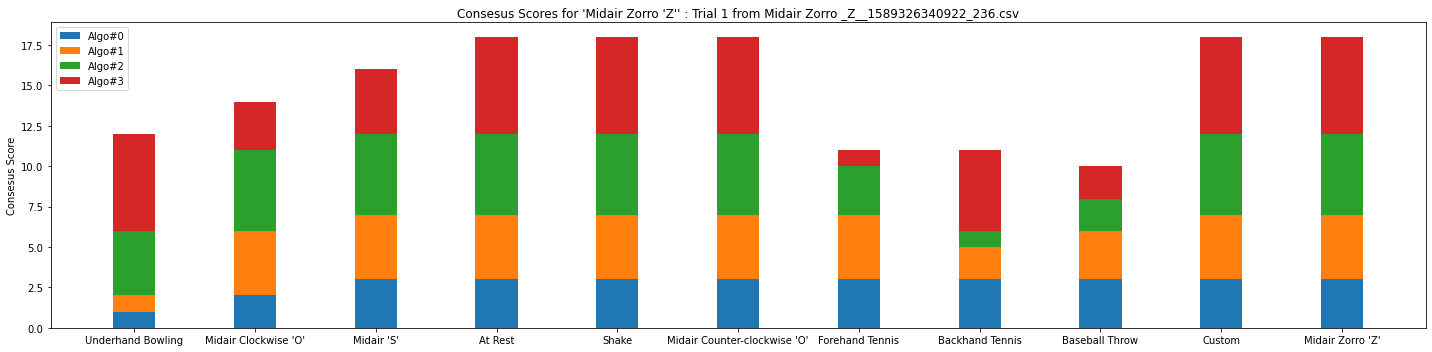

Incorrect : Best match for 'Forehand Tennis' Trial 1 is 'Baseball Throw' Trial 0 w/score: 10.0 (0.419s)

Midair 'S'True
Incorrect: SDFM:nan AVG: nan SC:nan guess:At Rest correct:Midair 'S' correct_index:4
Trying to determine 'Midair 'S'' : Trial 2 from Midair _S__1589326388431_273.csv = ['At Rest:nan', "Midair 'S':1.2747652401275225", "Midair 'S':1.252365219871675", "Midair 'S':2.0825676357153027"]
{'At Rest': 16, "Midair 'S'": 5, 'Shake': 18, "Midair Counter-clockwise 'O'": 16, "Midair Clockwise 'O'": 12, 'Backhand Tennis': 15, 'Forehand Tennis': 13, 'Baseball Throw': 16, 'Underhand Bowling': 18, "Midair Zorro 'Z'": 17, 'Custom': 18}
Correct : Best match for 'Midair 'S'' Trial 2 is 'Midair 'S'' Trial 4 w/score: 5.0 (0.027s)

Midair Clockwise 'O'True
Incorrect: SDFM:1.3078865759039524 AVG: 98808.57074041748 SC:55602.0530391769 guess:At Rest correct:Midair Clockwise 'O' correct_index:20
Incorrect: SDFM:1.2202636044853536 AVG: 5875.599508345793 SC:783.2916316172375 guess:Midair Counter-c

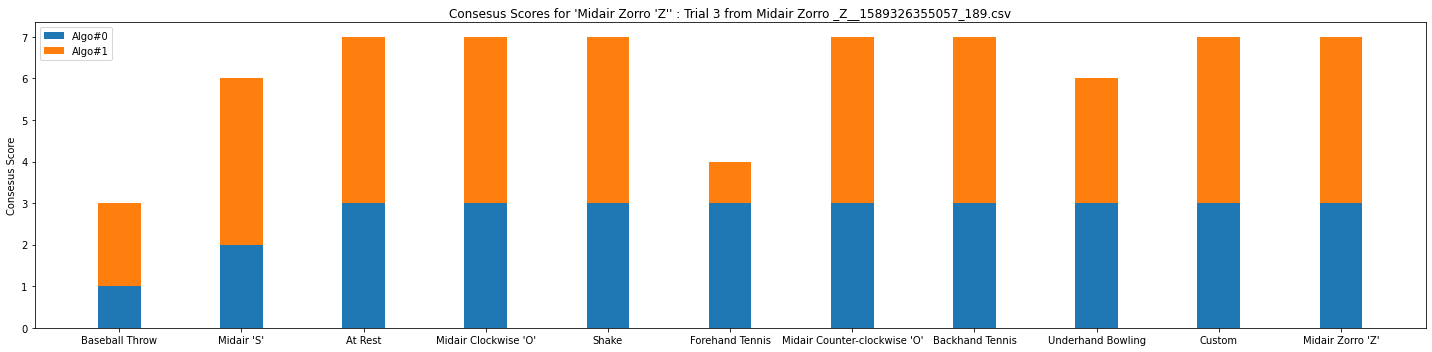

Incorrect : Best match for 'Forehand Tennis' Trial 0 is 'Baseball Throw' Trial 0 w/score: 3.0 (0.328s)

Midair 'S'True
Incorrect: SDFM:nan AVG: nan SC:nan guess:At Rest correct:Midair 'S' correct_index:1
Incorrect: SDFM:1.2305879343274184 AVG: 7323.896424798853 SC:1756.4133421482366 guess:Backhand Tennis correct:Midair 'S' correct_index:1
Trying to determine 'Midair 'S'' : Trial 0 from Midair _S__1589326372085_222.csv = ['At Rest:nan', 'Backhand Tennis:1.2305879343274184', "Midair 'S':1.1562495441855103", "Midair 'S':2.438875116886119"]
{'At Rest': 16, "Midair 'S'": 6, "Midair Clockwise 'O'": 11, 'Shake': 17, "Midair Counter-clockwise 'O'": 14, 'Backhand Tennis': 13, 'Forehand Tennis': 15, 'Underhand Bowling': 18, "Midair Zorro 'Z'": 18, 'Baseball Throw': 18, 'Custom': 18}
Correct : Best match for 'Midair 'S'' Trial 0 is 'Midair 'S'' Trial 3 w/score: 6.0 (0.033s)

Midair Clockwise 'O'True
Incorrect: SDFM:2.0149269178177387 AVG: 107453.00526590474 SC:25359.065916920023 guess:Midair Coun

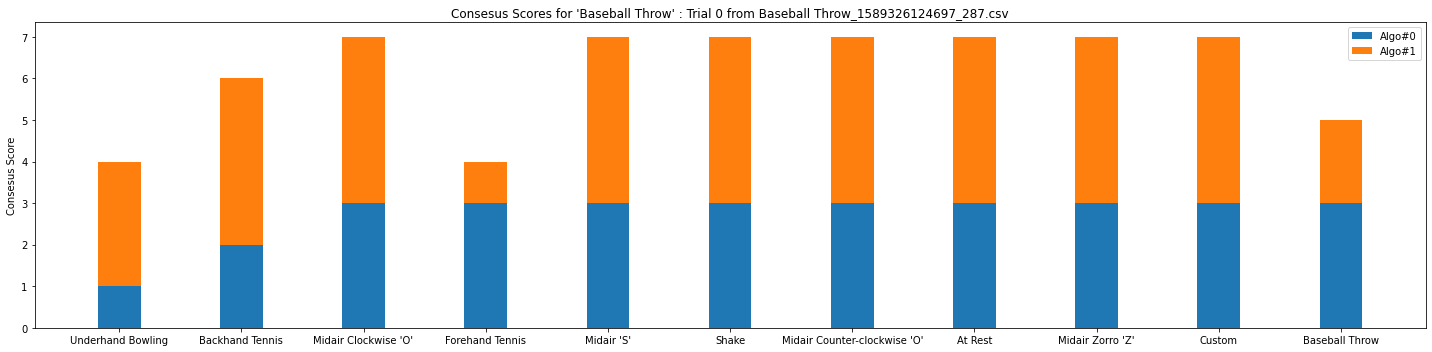

Incorrect : Best match for 'Forehand Tennis' Trial 2 is 'Underhand Bowling' Trial 1 w/score: 4.0 (0.349s)

Midair 'S'True
Incorrect: SDFM:nan AVG: nan SC:nan guess:At Rest correct:Midair 'S' correct_index:4
Incorrect: SDFM:1.0891861710087547 AVG: 8004.928794118265 SC:2236.1645977748058 guess:Backhand Tennis correct:Midair 'S' correct_index:1
Incorrect: SDFM:1.2048118844038016 AVG: 6689.640782202292 SC:664.4477938140825 guess:Midair Clockwise 'O' correct:Midair 'S' correct_index:5
Incorrect: SDFM:1.4894249273169957 AVG: 7061.42217590572 SC:2674.686415373643 guess:Midair Clockwise 'O' correct:Midair 'S' correct_index:2
Incorrect: SDFM:0.5856282906985528 AVG: 7151.429975935147 SC:3282.7083938297337 guess:Midair Zorro 'Z' correct:Midair 'S' correct_index:2
Incorrect: SDFM:1.2420653504112804 AVG: 118.58143525127139 SC:39.34683728093034 guess:At Rest correct:Midair 'S' correct_index:8
Incorrect: SDFM:0.8760476408034059 AVG: 108.01871678906214 SC:51.989546857108266 guess:At Rest correct:Midai

In [98]:
# Run experiments
# Note: remember, we want you to write your own generate_kfolds function
# You can use generate_kfolds_scikit instead if you'd like to test other parts of your code 
# but you must eventually write your own kfold split code for the assignment
gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

# TODO: switch this to generate_kfolds once you've written that method.
# For now, you can use our method `generate_kfolds_scikit`
list_folds = generate_kfolds(5, gesture_set, seed=5) 

# print out folds (for debugging)
#print("DEBUG: PRINTING OUT FOLDS")
#print_folds(list_folds)

# track multiple experiments
experiments = Experiments()

# run initial experiment
print("1")
results_x = run_matching_algorithm(list_folds, find_closest_match_euclid_signal, verbose=False)
results_x.title = "{}: Euclidean distance raw".format(gesture_set.name)

experiments.add(results_x)

# run second experiment 
print("2")
results_y = run_matching_algorithm(list_folds, find_closest_match_fft, verbose=False)
results_y.title = "{}: Euclidean distance FFT".format(gesture_set.name)
experiments.add(results_y)

print("3")
results_w = run_matching_algorithm(list_folds, find_closest_match_dtw)
results_w.title = "{}: Fast DTW".format(gesture_set.name)
experiments.add(results_w)

print("4")
results_z = run_matching_algorithm(list_folds, find_match_bring_in_the_expert, verbose=True, committee=True)
results_z.title = "{}: Expert Escalation Committee".format(gesture_set.name)
experiments.add(results_z)

print("5")
results_aa = run_matching_algorithm(list_folds, find_match_bring_in_the_expert, verbose=False, committee=False)
results_aa.title = "{}: Expert Escalation No Committee".format(gesture_set.name)
experiments.add(results_aa)


print(experiments.get_experiment_accuracies())
print("Top experiment")
experiments.get_top_performing_experiment().print_result()

# Visualizing Experiment Results
We've written a number of functions to help visualize experimental results. You'll likely want to add more, for example:
- Visualize incorrect matches. What happened? What could you do to improve your algorithm so these incorrect matches don't occur?

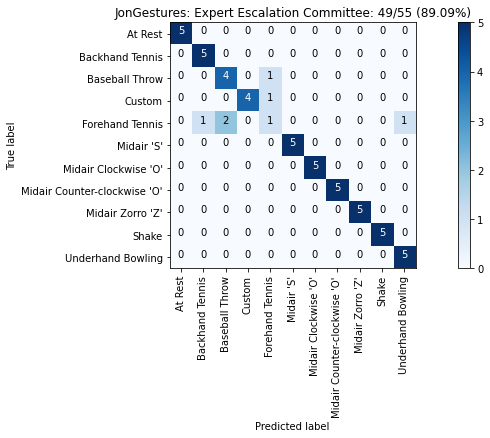

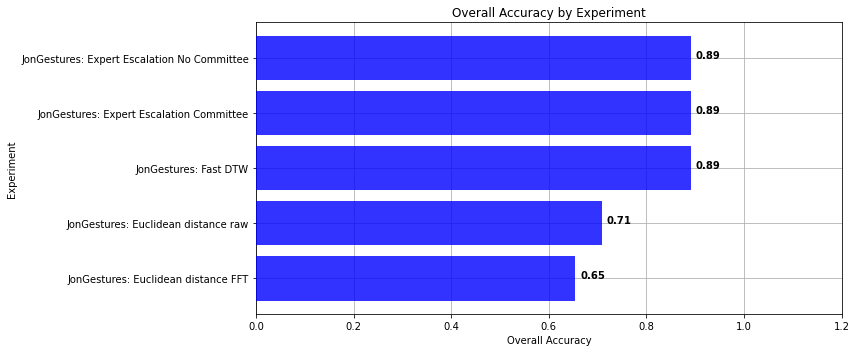

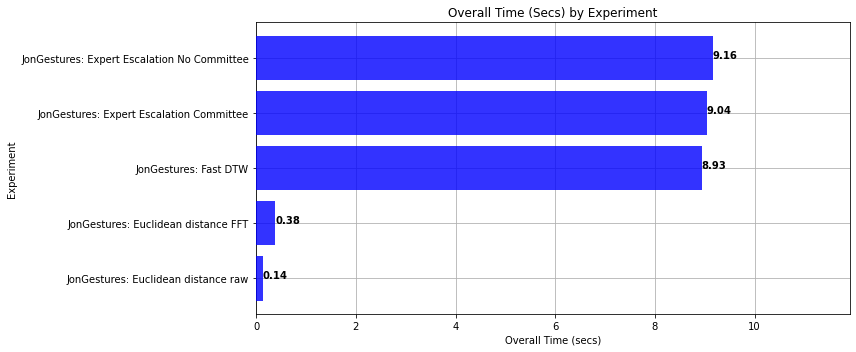

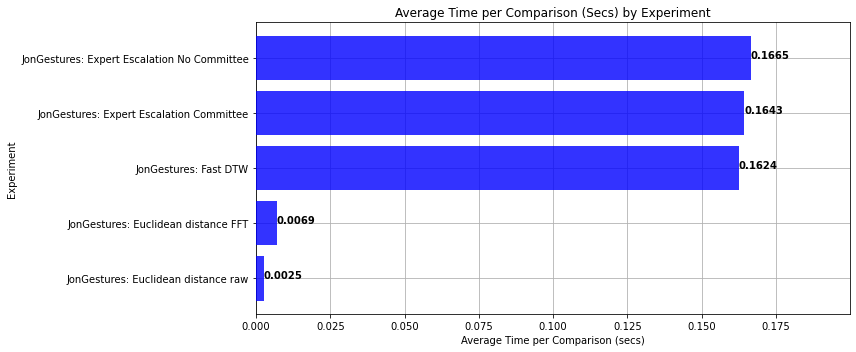

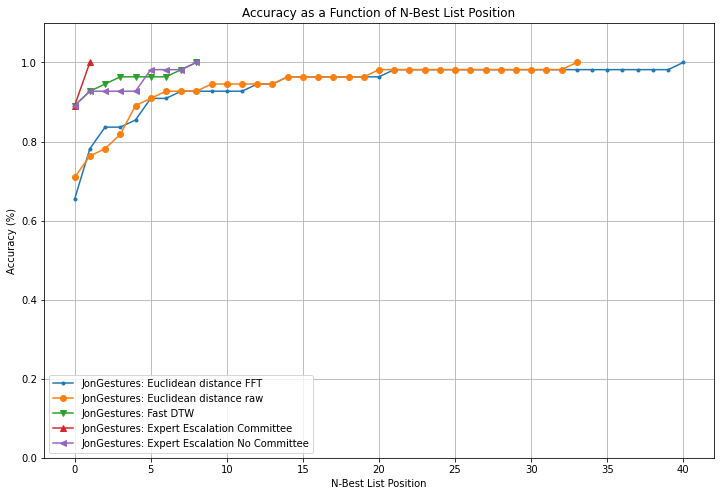

In [84]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.lines import Line2D

def plot_bar_graph_average_scores_by_gesture(classification_results):
    '''
    Plots the average scores for correct and incorrect matches
    A good matching algorithm should have much lower scores for correct
    matches than incorrect matches (if this is not the case, you'll want to work
    on improving your matching algorithm)
    '''
  
    correct_score_means = []
    incorrect_score_means = []
    gesture_names = classification_results.get_gesture_names()
    for gesture_name in gesture_names:
        scores_correct_matches = np.array(classification_results.get_correct_match_scores_for_gesture(gesture_name))
        scores_incorrect_matches = np.array(classification_results.get_incorrect_match_scores_for_gesture(gesture_name))

        if len(scores_correct_matches) > 0:
            correct_score_means.append(np.mean(scores_correct_matches))
        else:
            correct_score_means.append(0)
        
        if len(scores_incorrect_matches) > 0:
            incorrect_score_means.append(np.mean(scores_incorrect_matches))
        else:
            incorrect_score_means.append(0)

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, correct_score_means, bar_width, alpha=opacity, color='b', label='Correct')
    bars_incorrect = plt.bar(index + bar_width, incorrect_score_means, bar_width, alpha=opacity, color='g', label='Incorrect')

    plt.xlabel('Gesture')
    plt.ylabel('Average Scores')
    plt.title('Average Scores By Gesture and Correctness\n' + classification_results.get_title())
    plt.xticks(index - bar_width, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_average_nbestlist_location_by_gesture(classification_results):
    '''
    Plots the average n-best list location for each gesture
    '''
    avg_nbestlist_location = []
    gesture_names = classification_results.get_gesture_names()

    for gesture_name in gesture_names:
        correct_match_indices_in_nbestlist = np.array(classification_results.get_correct_match_indices_in_nbestlist_for_gesture(gesture_name))
        avg_nbestlist_location.append(np.mean(correct_match_indices_in_nbestlist))

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    # bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, avg_nbestlist_location, alpha=opacity, color='b', label='Avg NBest List Location')

    plt.xlabel('Gesture')
    plt.ylabel('Average NBest List Location')
    plt.title('Average NBest List Location By Gesture\n' + classification_results.get_title())
    plt.xticks(index, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_classification_result_as_confusion_matrix(classification_result, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Code based on:
      - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    See also
      - https://stackoverflow.com/a/35572520
      - Plotting with matshow: https://matplotlib.org/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py
    """
    cm = classification_result.get_confusion_matrix()
    classes = classification_result.get_gesture_names()
    plot_confusion_matrix(cm, classes, classification_result.get_title(), normalize, cmap)
    
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    plt.figure(figsize=(12, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_bar_graph_overall_performance(experiments):
    '''
    Plots a bar graph of overall performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_accuracies = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_accuracies.append(experiment.get_accuracy())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_accuracies, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_accuracies):
        ax.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Accuracy')
    plt.xlim(0, 1.2)
    plt.title('Overall Accuracy by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_overall_time(experiments):
    '''
    Plots a bar graph of overall computation time per experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_computation_time();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.total_time)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Time (secs)')
    plt.xlim(0, list_experiments[-1].total_time * 1.3)
    plt.title('Overall Time (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_avg_time_per_comparison(experiments):
    '''
    Plots a bar graph of average computation time per comparison for each experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_avg_time_per_comparison();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.get_avg_time_per_comparison())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.4f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Average Time per Comparison (secs)')
    plt.xlim(0, list_experiments[-1].get_avg_time_per_comparison() * 1.2)
    plt.title('Average Time per Comparison (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_nbestlist_performance(experiments):
    '''
    Plots a line graph of n-best list performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    marker = itertools.cycle(('.','o','v','^','<','>','8',
                              's','p','P','*','h','H','+','x','X','D','d','|',
                              '_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',')) 
    
    for experiment in list_experiments:
        nbest_list_performance = experiment.get_nbestlist_performance()
        axes.plot(nbest_list_performance, marker=next(marker), label=experiment.title)
    
    axes.grid()
    axes.legend()
    axes.set_title("Accuracy as a Function of N-Best List Position")
    axes.set_ylabel("Accuracy (%)")
    axes.set_ylim(0, 1.1)
    axes.set_xlabel("N-Best List Position")

plot_classification_result_as_confusion_matrix(results_z)
plot_bar_graph_overall_performance(experiments)
plot_bar_graph_overall_time(experiments)
plot_bar_graph_avg_time_per_comparison(experiments)
plot_nbestlist_performance(experiments)

# Comparing performance across gesture sets


Title: AGestures: Expert with Committee: 45/55 (81.82%)
Optional arguments: {'verbose': False, 'committee': True}
Took 1.131s for 55 comparisons (avg=0.021s per match)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 3 2 0 0 0 0 0 0 0]
 [4 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 4 1 0 0 0]
 [0 0 0 0 0 0 1 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 1 0 0 1 0 0 0 0 0 3]]

Title: AlexandraGestures: Expert with Committee: 45/55 (81.82%)
Optional arguments: {'verbose': False, 'committee': True}
Took 3.626s for 55 comparisons (avg=0.066s per match)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 0 0 0 1 0 0 1]
 [0 2 3 0 0 0 0 0 0 0 0]
 [0 0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 4 1]
 [1 0 0 0 0 0 0 0 0 0 4]]

Title: AlexisGestures: Expert with Committee: 38/55 (69.09%)
Optional arguments: {'verbose': False, '

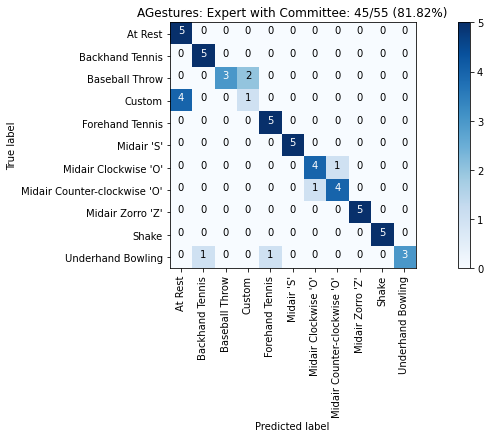

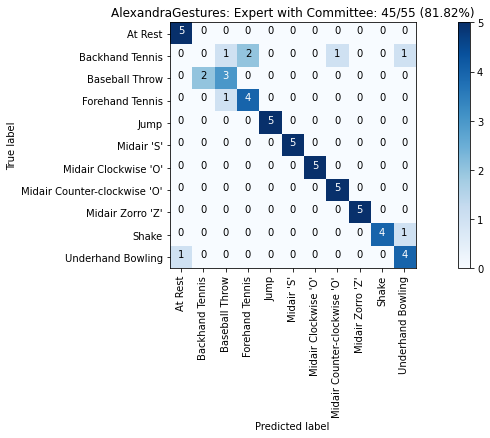

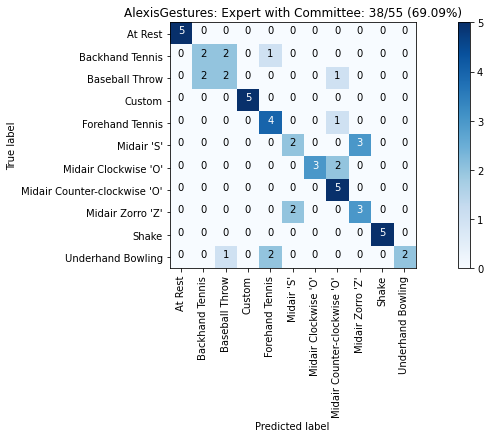

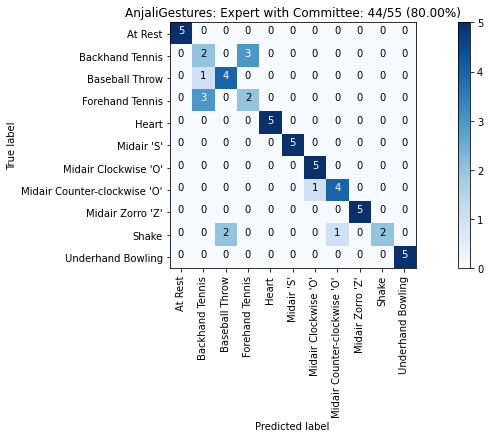

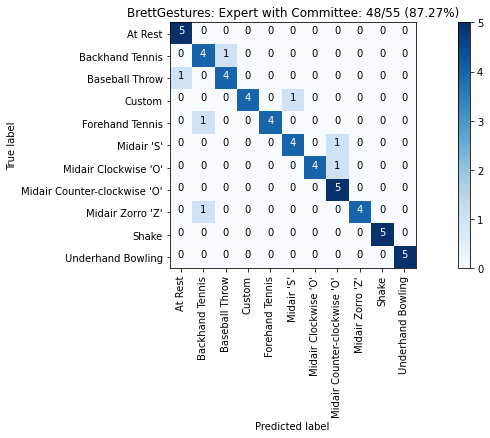

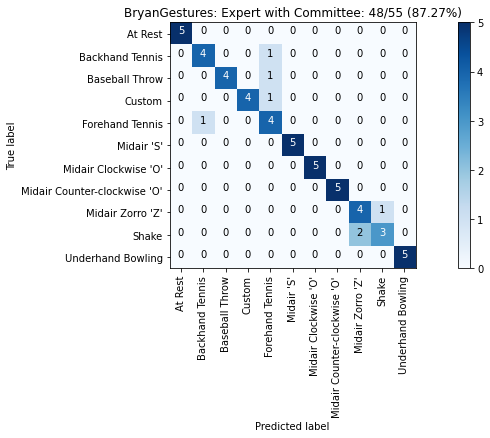

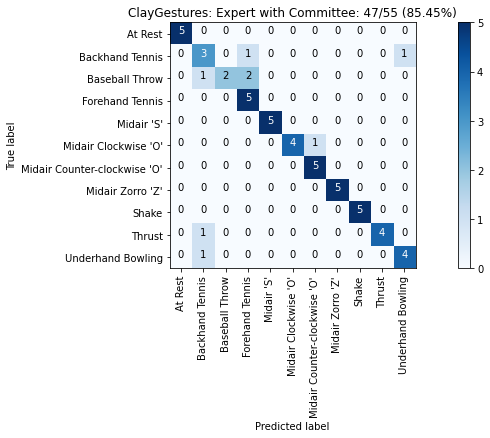

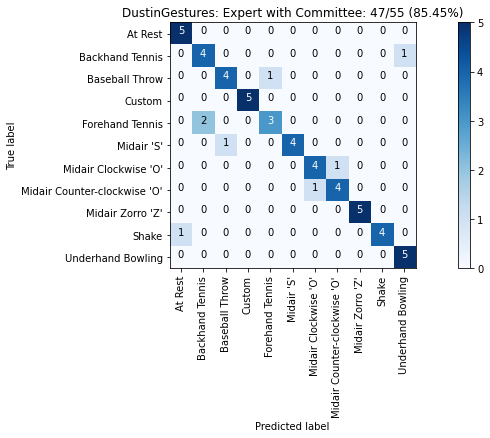

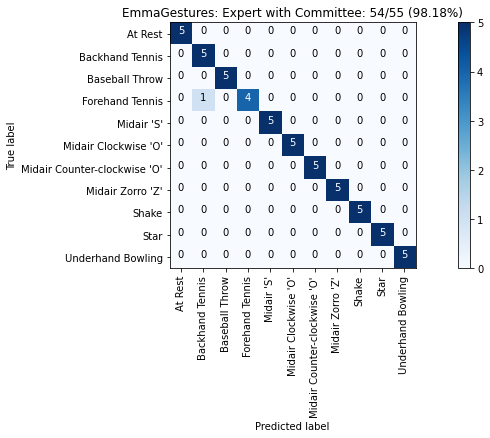

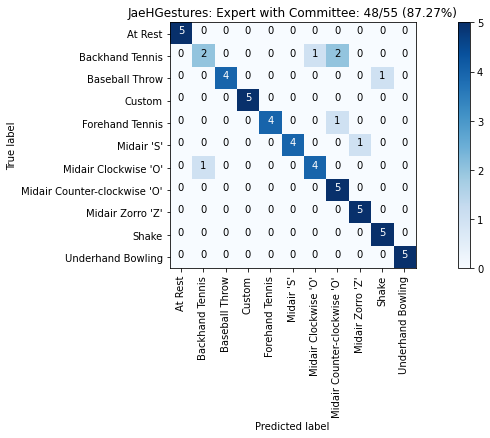

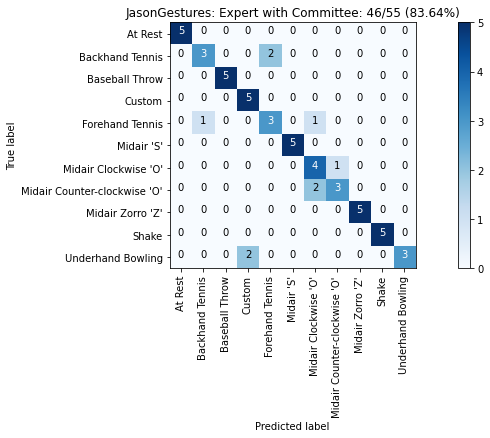

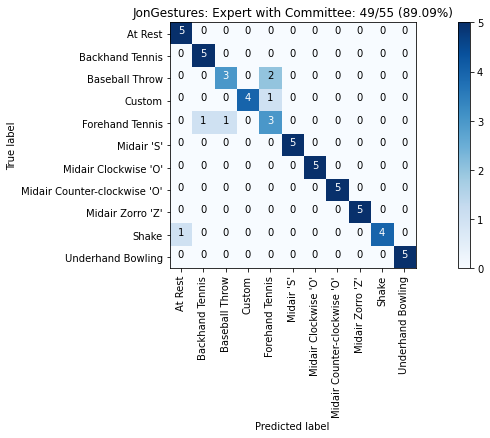

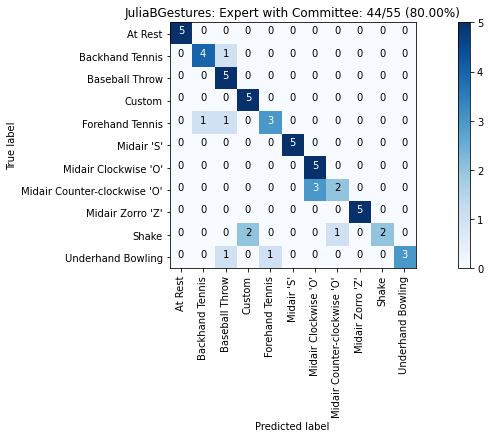

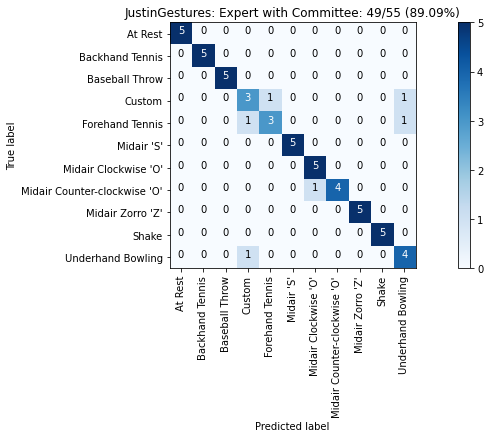

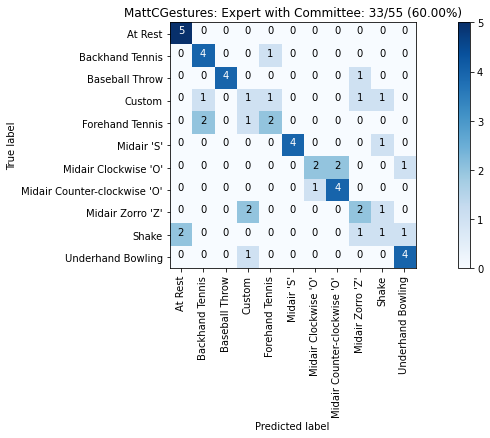

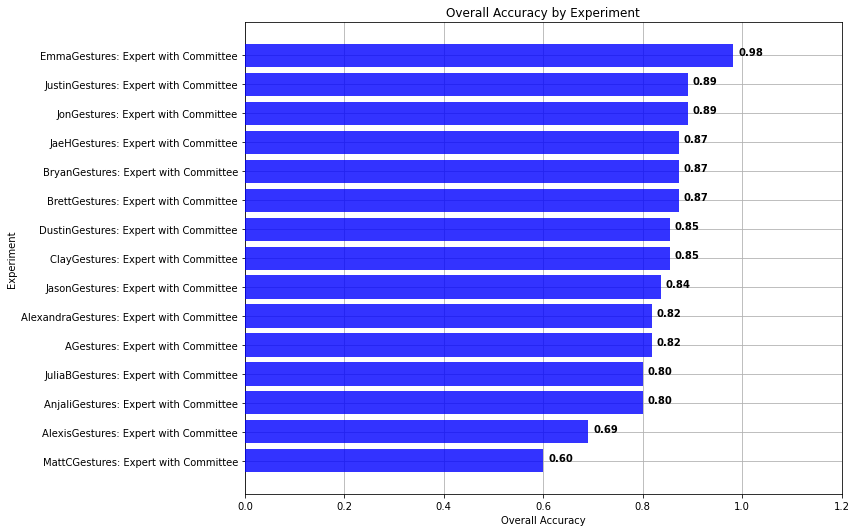

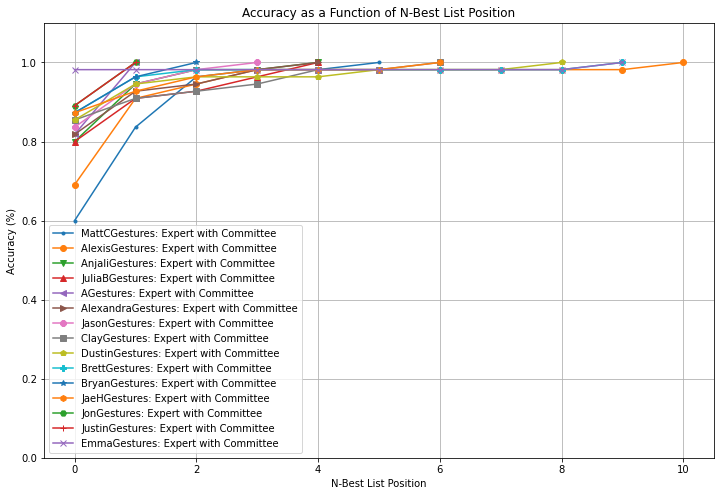

In [96]:
# track multiple experiments
experiments = Experiments()

# Run experiments across all gesture sets
for gesture_set_name, gesture_set in map_gesture_sets.items():
   
    list_folds = generate_kfolds_scikit(5, gesture_set, seed=5)
    
    # run initial experiment
    results = run_matching_algorithm(list_folds, find_match_bring_in_the_expert, verbose=False, committee=True)
    results.title = "{}: Expert with Committee".format(gesture_set.name)
    results.print_result()
    
    plot_classification_result_as_confusion_matrix(results)
    experiments.add(results)

avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")
plot_bar_graph_overall_performance(experiments)
plot_nbestlist_performance(experiments)

In [97]:
avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")

Average accuracy: 0.8303030303030303 Stdev=0.08622263875771509
